In [ ]:
!pip install tensorflow

In [ ]:
import cv2
import os
import random
import tensorflow as tf
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array, load_img
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare or Set the Dataset from kaggle.com

In [ ]:
from google.colab import files
files.upload()  # choose your 'kaggle.json' file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"raflyaulya","key":"a4d3298f48affdfa6e25867ddc1d95ac"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# !kaggle datasets download -d zynicide/wine-reviews
!kaggle datasets download -d emmarex/plantdisease
# emmarex/plantdisease

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 99% 650M/658M [00:11<00:00, 118MB/s]
100% 658M/658M [00:11<00:00, 59.0MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("plantdisease.zip", 'r') as zip_ref:
    zip_ref.extractall("plantdisease")


# Описание наборов данных

In [ ]:

source_path = 'plantdisease/PlantVillage' # Update the source_path

DATA_CLASSES = ['Bell Pepper Bacterial Spot', 'Potato Healthy', 'Bell Pepper Healthy']
data_dirs = ['Pepper__bell___Bacterial_spot', 'Potato___healthy', 'Pepper__bell___healthy']

for i, dir in enumerate(data_dirs):
    class_dir = os.path.join(source_path, dir)
    # Check if the directory exists before trying to list its contents
    if os.path.exists(class_dir):
        print(f'There are {len(os.listdir(class_dir))} images of {DATA_CLASSES[i]}')
    else:
        print(f"Directory not found: {class_dir}")

There are 997 images of Bell Pepper Bacterial Spot
There are 152 images of Potato Healthy
There are 1478 images of Bell Pepper Healthy


Этот цикл перебирает каждое имя папки в data_dirs.
- enumerate используется для получения как индекса (i), так и значения (dir) каждого элемента в списке.
- os.path.join(source_path, dir): Эта строка объединяет source_path и текущее имя папки (dir), чтобы создать полный путь к папке с изображениями (class_dir).
- os.path.exists(class_dir): Это проверяет, существует ли папка на самом деле.
- Если папка существует:
  - os.listdir(class_dir): Эта функция перечисляет все файлы (которые предполагаются изображениями) внутри папки.
  - len(...): Эта функция получает общее количество изображений в папке.
  - print(...): Эта функция выводит сообщение, показывающее количество изображений и соответствующее имя класса.
Если папка не существует, выводится сообщение, указывающее, что каталог не найден.

In [ ]:
# Cek struktur direktori dataset
for root, dirs, files in os.walk("plantdisease"):
    print(f"folder: {root}")
    print(f"Subfolder: {dirs}")
    print(f"Total file: {len(files)}")
    print("-" * 40)


folder: plantdisease
Subfolder: ['PlantVillage', 'plantvillage']
Total file: 0
----------------------------------------
folder: plantdisease/PlantVillage
Subfolder: ['Potato___Early_blight', 'Tomato_healthy', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Potato___healthy', 'Tomato__Tomato_mosaic_virus', 'Potato___Late_blight', 'Pepper__bell___Bacterial_spot', 'Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato_Bacterial_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_Early_blight', 'Tomato_Leaf_Mold', 'Tomato_Late_blight', 'Pepper__bell___healthy']
Total file: 0
----------------------------------------
folder: plantdisease/PlantVillage/Potato___Early_blight
Subfolder: []
Total file: 1000
----------------------------------------
folder: plantdisease/PlantVillage/Tomato_healthy
Subfolder: []
Total file: 1591
----------------------------------------
folder: plantdisease/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus
Subfolder: []
Total file: 3209
--------------------

# Бинарный классификатор

## Создадим папки для тренировочных, валидационных, и тестированных данных

In [ ]:
root_binary = 'binary_data'

os.makedirs(os.path.join(root_binary, 'train'))
os.makedirs(os.path.join(root_binary, 'validation'))
os.makedirs(os.path.join(root_binary, 'testing'))

os.makedirs(os.path.join(root_binary, 'train/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'train/potato_healthy'))

os.makedirs(os.path.join(root_binary, 'validation/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'validation/potato_healthy'))

os.makedirs(os.path.join(root_binary, 'testing/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'testing/potato_healthy'))

## Разделим данные на треировки, валидации и тестирования

In [ ]:
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, TRAINING_SPLIT, VALIDATION_SPLIT, TESTING_SPLIT):
    filtered_files = []

    for file_name in os.listdir(SOURCE):
        file_path = os.path.join(SOURCE, file_name)

        if os.path.getsize(file_path):
            filtered_files.append(file_name)
        else:
            print('{} is zero length, so ignoring.'.format(file_name))

    # Split the files
    random_files = random.sample(filtered_files, len(filtered_files))
    split_train = int(TRAINING_SPLIT * len(filtered_files))
    split_val = split_train + int(VALIDATION_SPLIT * len(filtered_files))
    split_test = split_val + int(TESTING_SPLIT * len(filtered_files))

    training_files = random_files[:split_train]
    val_files = random_files[split_train:split_val]
    test_files = random_files[split_val:]

    # Copy the files
    for file_name in training_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TRAINING, file_name))

    for file_name in val_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(VALIDATION, file_name))

    for file_name in test_files:
        copyfile(os.path.join(SOURCE, file_name), os.path.join(TESTING, file_name))

- Инициализация:
  - filtered_files = []: Создается пустой список с именем filtered_files для хранения имен допустимых файлов.

- Фильтрация файлов:
  - Код перебирает каждое имя файла (file_name) в каталоге SOURCE с помощью os.listdir(SOURCE).
  - Для каждого имени файла (file_name) он создает полный путь к файлу (file_path) с помощью os.path.join(SOURCE, file_name).
  - Он проверяет, имеет ли файл размер больше нуля, используя os.path.getsize(file_path).
    - Если файл имеет размер, он добавляется в список filtered_files.
    - Если файл пуст, выводится сообщение, указывающее, что он игнорируется.

- Разделение данных:
  - random_files = random.sample(filtered_files, len(filtered_files)): Эта строка случайным образом перемешивает filtered_files, чтобы обеспечить случайное распределение данных по разбиениям.
  - split_train, split_val и split_test рассчитываются на основе предоставленных коэффициентов разделения (TRAINING_SPLIT, VALIDATION_SPLIT, TESTING_SPLIT) и общего количества отфильтрованных файлов. Эти значения определяют границы для каждого разбиения данных.
  - training_files, val_files и test_files назначаются срезы списка random_files на основе рассчитанных точек разделения.

- Копирование файлов:
  - Затем код перебирает каждый из списков файлов для обучения, валидации и тестирования.
  - С помощью copyfile он копирует каждый файл из каталога SOURCE в соответствующий каталог назначения (TRAINING, VALIDATION, TESTING). Функция os.path.join используется для создания полных путей источника и назначения для каждого файла.

In [ ]:
source = source_path
BELL_PEPPER_BAC_DIR = f"{source}/" + data_dirs[0]
POTATO_HEALTHY_DIR = f"{source}/" + data_dirs[1]

TRAINING_DIR = "binary_data/train/"
VAL_DIR = "binary_data/validation/"
TEST_DIR = "binary_data/testing/"

TRAINING_BELL_PEPPER_BAC_DIR = os.path.join(TRAINING_DIR, "bell_pepper_bac/")
VAL_BELL_PEPPER_BAC_DIR = os.path.join(VAL_DIR, "bell_pepper_bac/")
TEST_BELL_PEPPER_BAC_DIR = os.path.join(TEST_DIR, "bell_pepper_bac/")

TRAINING_POTATO_HEALTHY_DIR = os.path.join(TRAINING_DIR, "potato_healthy/")
VAL_POTATO_HEALTHY_DIR = os.path.join(VAL_DIR, "potato_healthy/")
TEST_POTATO_HEALTHY_DIR = os.path.join(TEST_DIR, "potato_healthy/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(TRAINING_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_POTATO_HEALTHY_DIR):
        os.remove(file.path)

if len(os.listdir(VAL_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(VAL_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(VAL_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_POTATO_HEALTHY_DIR):
        os.remove(file.path)

if len(os.listdir(TEST_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(TEST_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TEST_POTATO_HEALTHY_DIR):
        os.remove(file.path)


# Define proportion of images used for training
split_train_size = .7
split_val_size = .2
split_test_size = .1

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(BELL_PEPPER_BAC_DIR, TRAINING_BELL_PEPPER_BAC_DIR, VAL_BELL_PEPPER_BAC_DIR, TEST_BELL_PEPPER_BAC_DIR,
           split_train_size, split_val_size, split_test_size)
split_data(POTATO_HEALTHY_DIR, TRAINING_POTATO_HEALTHY_DIR, VAL_POTATO_HEALTHY_DIR, TEST_POTATO_HEALTHY_DIR,
           split_train_size, split_val_size, split_test_size)


# Check that the number of images matches the expected output
print(f"There are {len(os.listdir(TRAINING_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for training")
print(f"There are {len(os.listdir(TRAINING_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for training")

print(f"\nThere are {len(os.listdir(VAL_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for validation")
print(f"There are {len(os.listdir(VAL_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for validation")

print(f"\nThere are {len(os.listdir(TEST_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for testing")
print(f"There are {len(os.listdir(TEST_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for testing")


There are 697 images of Bell Pepper Bacterial Spot for training
There are 106 images of Potato Healthy for training

There are 199 images of Bell Pepper Bacterial Spot for validation
There are 30 images of Potato Healthy for validation

There are 101 images of Bell Pepper Bacterial Spot for testing
There are 16 images of Potato Healthy for testing


- source: Эта переменная хранит базовый путь к набору данных изображений, который, вероятно, был определен ранее в блокноте как source_path.
- BELL_PEPPER_BAC_DIR, POTATO_HEALTHY_DIR: Эти переменные хранят пути к исходным каталогам, содержащим изображения 'бактериальной пятнистости перца' и 'здорового картофеля' соответственно. Они формируются путем объединения пути source с соответствующими именами каталогов из списка data_dirs.
- TRAINING_DIR, VAL_DIR, TEST_DIR: Эти переменные определяют пути к основным каталогам для данных обучения, валидации и тестирования.
- Остальные строки (например, TRAINING_BELL_PEPPER_BAC_DIR, VAL_BELL_PEPPER_BAC_DIR и т. д.) создают пути к подкаталогам в каталогах обучения, валидации и тестирования. Эти подкаталоги будут содержать изображения для каждого конкретного класса. Функция os.path.join используется для создания путей, не зависящих от платформы, путем правильного соединения компонентов каталога.

- split_train_size, split_val_size, split_test_size: Эти переменные определяют пропорции данных, которые будут использоваться для обучения, валидации и тестирования соответственно.
- Функция split_data (определенная ранее в блокноте) вызывается для фактического разделения изображений на каталоги обучения, валидации и тестирования. Она принимает исходный каталог, целевые каталоги и пропорции разделения в качестве аргументов.


## Генерации данных для классификации

In [ ]:
def train_val_testing_generators(TRAINING_DIR, VALIDATION_DIR, TESTING_DIR):
    # Instantiate the ImageDataGenerator class
    train_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                     rotation_range = 40,
                                     width_shift_range = .2,
                                     height_shift_range = .2,
                                     shear_range = .2,
                                     zoom_range = .2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    train_generator = train_datagen.flow_from_directory(directory = TRAINING_DIR,
                                                      batch_size = 64,
                                                      class_mode = 'categorical',
                                                      target_size = (256, 256))

    # Instantiate the ImageDataGenerator class
    validation_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                          rotation_range = 40,
                                          width_shift_range = .2,
                                          height_shift_range = .2,
                                          shear_range = .2,
                                          zoom_range = .2,
                                          horizontal_flip = True,
                                          fill_mode = 'nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    validation_generator = validation_datagen.flow_from_directory(directory = VALIDATION_DIR,
                                                                batch_size = 64,
                                                                class_mode = 'categorical',
                                                                target_size = (256, 256))

    # Instantiate the ImageDataGenerator class
    testing_datagen = ImageDataGenerator(rescale = 1.0 / 255.,
                                          rotation_range = 40,
                                          width_shift_range = .2,
                                          height_shift_range = .2,
                                          shear_range = .2,
                                          zoom_range = .2,
                                          horizontal_flip = True,
                                          fill_mode = 'nearest')

    # Pass in the appropriate arguments to the flow_from_directory method
    testing_generator = testing_datagen.flow_from_directory(directory = TESTING_DIR,
                                                                batch_size = 64,
                                                                class_mode = 'categorical',
                                                                target_size = (256, 256))


    return train_generator, validation_generator, testing_generator


- ImageDataGenerator:
  - Этот класс из tensorflow.keras.preprocessing.image используется для создания генераторов данных. Это мощный инструмент для аугментации данных, который помогает создавать вариации существующих изображений для увеличения размера обучающего набора данных и повышения устойчивости модели.

- Аугментация данных:
  - Внутри ImageDataGenerator вы видите такие параметры, как rotation_range, width_shift_range, height_shift_range, shear_range, zoom_range и horizontal_flip. Они определяют преобразования, которые будут случайным образом применяться к изображениям во время обучения. Например, rotation_range=40 означает, что изображения могут быть повернуты на угол до 40 градусов. Это помогает модели научиться распознавать объекты, даже если они находятся под разными углами или в разных положениях.

- flow_from_directory:
  - Этот метод ImageDataGenerator подключает генератор к вашим данным изображений, хранящимся в каталогах.
  - directory: Указывает путь к главному каталогу, где расположены ваши обучающие, валидационные или тестовые изображения. Внутри этого каталога должны быть подкаталоги, по одному для каждого класса (например, 'bell_pepper_bac', 'potato_healthy').
  - batch_size: Контролирует, сколько изображений обрабатывается за один раз. Размер пакета 64 означает, что модель будет обновляться после просмотра 64 изображений.
  - class_mode: 'categorical' указывает, что это проблема многоклассовой классификации, и генератор будет создавать однократные закодированные метки для каждого класса.
  - target_size: Указывает размеры (ширина, высота), до которых будут изменены все изображения. (256, 256) означает, что изображения будут изменены до 256x256 пикселей.

- Создание генераторов:
  - Функция создает три генератора (train_generator, validation_generator, testing_generator), используя вышеуказанные шаги, каждый из которых указывает на соответствующие каталоги данных.

- Возврат генераторов:
  - Функция возвращает эти три генератора. Эти генераторы будут использоваться позже при обучении и оценке вашей модели с помощью model.fit and model.evaluate.

In [ ]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_testing_generators(TRAINING_DIR, VAL_DIR, TEST_DIR)


Found 803 images belonging to 2 classes.
Found 229 images belonging to 2 classes.
Found 117 images belonging to 2 classes.


# Параметры архитектур и обучения нейронных сетей, использованные для обучения

## Построим модель

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │           1,026 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,087,426 (49.92 MB)

 Trainable params: 13,087,426 (49.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

- model.compile(): Эта строка - вызов функции, которая запускает процесс компиляции. Компиляция по сути подготавливает модель к обучению.

- optimizer=Adam(): Этот аргумент определяет алгоритм оптимизации, используемый для обновления внутренних параметров модели (весов и смещений) во время обучения.
  - Adam - популярный алгоритм оптимизации, известный своей эффективностью во многих задачах глубокого обучения.
  - Оптимизаторы играют решающую роль в направлении модели к нахождению наилучшего набора параметров для минимизации функции потерь.

- loss='binary_crossentropy': Этот аргумент определяет функцию потерь, которая измеряет, насколько хорошо предсказания модели соответствуют фактическим меткам обучающих данных.
  - binary_crossentropy - часто используемая функция потерь для задач бинарной классификации (где вы пытаетесь классифицировать данные на две категории).
  - Цель обучения - минимизировать эту функцию потерь, что означает, что модель становится лучше в правильном прогнозировании.

- metrics=['accuracy']: Этот аргумент определяет метрики, используемые для оценки производительности модели во время и после обучения.
  - accuracy (точность) - распространенная метрика, которая рассчитывает процент правильно классифицированных образцов.
  - Отслеживая эти метрики, вы можете отслеживать прогресс вашей модели и видеть, насколько хорошо она обучается.

## Тренировать

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data = validation_generator,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 169s 12s/step - accuracy: 0.7906 - loss: 0.5750 - val_accuracy: 0.8690 - val_loss: 0.4104
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 198s 12s/step - accuracy: 0.8526 - loss: 0.4167 - val_accuracy: 0.8690 - val_loss: 0.2535
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 206s 14s/step - accuracy: 0.8609 - loss: 0.2477 - val_accuracy: 0.8690 - val_loss: 0.1781
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 161s 12s/step - accuracy: 0.8843 - loss: 0.1820 - val_accuracy: 0.9738 - val_loss: 0.1688
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 161s 12s/step - accuracy: 0.9374 - loss: 0.1506 - val_accuracy: 0.8865 - val_loss: 0.1605
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 211s 12s/step - accuracy: 0.9322 - loss: 0.1773 - val_accuracy: 0.9389 - val_loss: 0.1137
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 193s 12s/step - accuracy: 0.9705 - loss: 0.1049 - val_accuracy: 0.9825 - val_loss: 0.0974
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 201s 12s/step - accuracy: 0.9823 - loss: 0.0813 - val_accuracy: 0.9258 - val_

# Графики обучения для архитектур нейронных сетей с лучшими характеристиками эффективности

## Plot performance

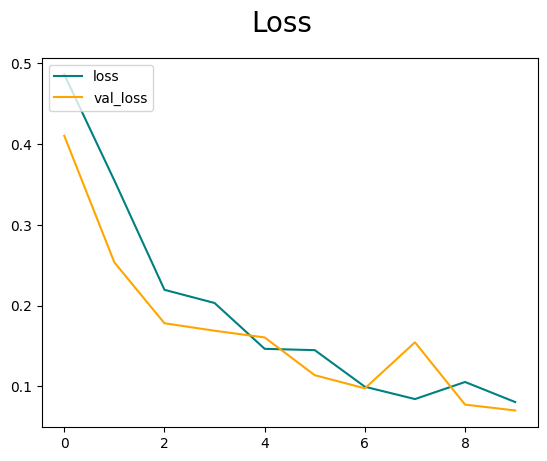

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

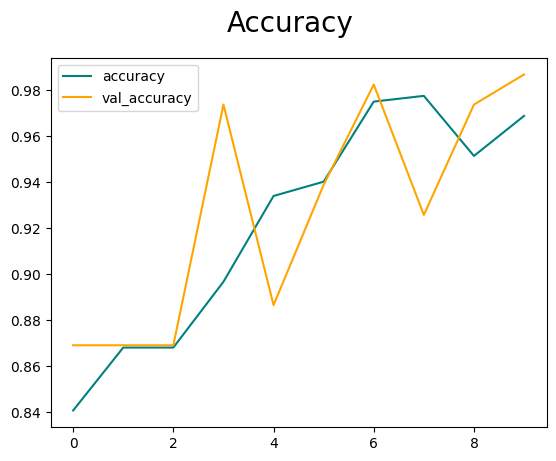

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## Evaluate with Test data

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
final_predictions = model.predict(testing_generator)

2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step


In [ ]:
true_labels= np.squeeze(testing_generator.classes)

In [ ]:
binary_preds = np.argmax(final_predictions, axis=1)

In [ ]:
pre.update_state(true_labels, binary_preds)
re.update_state(true_labels, binary_preds)
acc.update_state(true_labels, binary_preds)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision: 0.2857142984867096, Recall: 0.25, Accuracy: 0.811965823173523


Здесь нормальная accuracy но плохие precision и recall потому что наш датасет для тестирование не равномерный: 101 для класса 0 и 16 для класса 1

In [ ]:
# Function to load and preprocess an image for prediction
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

In [ ]:
# Path to the image you want to predict
image_path0 = f'{source}/Pepper__bell___Bacterial_spot/3b9a94fb-856a-4576-94e3-6c16bf01118f___JR_B.Spot 8956.JPG'
image_path1 = f'{source}/Potato___healthy/1ae826e2-5148-47bd-a44c-711ec9cc9c75___RS_HL 1954.JPG'


## Predict

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


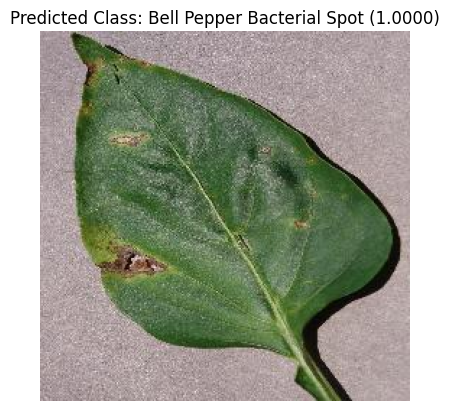

In [ ]:
loaded_image = image_path0

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# Make a prediction
predictions = model.predict(input_image)

# Decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# Display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

- image_path0 - это переменная, вероятно, определенная ранее, которая хранит путь к файлу изображения, которое мы хотим классифицировать.
- loaded_image присваивается значение image_path0, по сути указывая на файл изображения.
- Здесь вызывается model.predict с предварительно обработанным изображением (input_image) в качестве входных данных. Именно здесь обученная модель фактически используется для классификации изображения.
- Переменная predictions будет хранить выходные данные модели, которые, вероятно, представляют собой массив вероятностей для каждого возможного класса.

- np.argmax(predictions): Эта строка находит индекс класса с наибольшей вероятностью в массиве predictions.
- predicted_class_label = DATA_CLASSES[predicted_class_index]: Используя полученный выше индекс, эта строка извлекает соответствующую метку класса из списка DATA_CLASSES (который, вероятно, содержит названия различных болезней растений или категорий здоровых растений).
- predicted_probability = predictions[0][predicted_class_index]: Эта строка извлекает фактическое значение вероятности, связанное с предсказанным классом.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


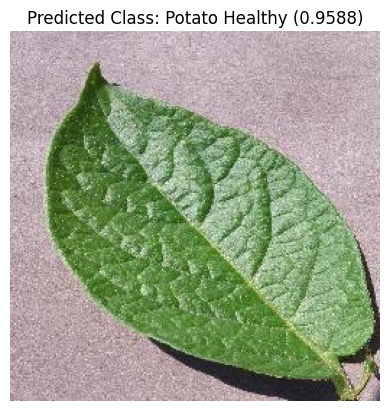

In [ ]:
loaded_image = image_path1

# Load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# make a prediction
predictions = model.predict(input_image)

# decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()


# Многоклассовый классификатор

## Model A (without pre-trained model)

## Создадим папку

In [ ]:
root_binary = 'multi_class'

os.makedirs(os.path.join(root_binary, 'train'))
os.makedirs(os.path.join(root_binary, 'validation'))
os.makedirs(os.path.join(root_binary, 'testing'))

os.makedirs(os.path.join(root_binary, 'train/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'train/potato_healthy'))
os.makedirs(os.path.join(root_binary, 'train/bell_pepper_healthy'))

os.makedirs(os.path.join(root_binary, 'validation/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'validation/potato_healthy'))
os.makedirs(os.path.join(root_binary, 'validation/bell_pepper_healthy'))

os.makedirs(os.path.join(root_binary, 'testing/bell_pepper_bac'))
os.makedirs(os.path.join(root_binary, 'testing/potato_healthy'))
os.makedirs(os.path.join(root_binary, 'testing/bell_pepper_healthy'))

## Разделим данных на данные для обучения, валидации, и тестирования

In [ ]:
BELL_PEPPER_BAC_DIR = f"{source}/" + data_dirs[0]
POTATO_HEALTHY_DIR = f"{source}/" + data_dirs[1]
BELL_PEPPER_HEALTHY_DIR = f"{source}/" + data_dirs[2]

TRAINING_DIR = "multi_class/train/"
VAL_DIR = "multi_class/validation/"
TEST_DIR = "multi_class/testing/"

TRAINING_BELL_PEPPER_BAC_DIR = os.path.join(TRAINING_DIR, "bell_pepper_bac/")
VAL_BELL_PEPPER_BAC_DIR = os.path.join(VAL_DIR, "bell_pepper_bac/")
TEST_BELL_PEPPER_BAC_DIR = os.path.join(TEST_DIR, "bell_pepper_bac/")

TRAINING_POTATO_HEALTHY_DIR = os.path.join(TRAINING_DIR, "potato_healthy/")
VAL_POTATO_HEALTHY_DIR = os.path.join(VAL_DIR, "potato_healthy/")
TEST_POTATO_HEALTHY_DIR = os.path.join(TEST_DIR, "potato_healthy/")

TRAINING_BELL_PEPPER_HEALTHY_DIR = os.path.join(TRAINING_DIR, "bell_pepper_healthy/")
VAL_BELL_PEPPER_HEALTHY_DIR = os.path.join(VAL_DIR, "bell_pepper_healthy/")
TEST_BELL_PEPPER_HEALTHY_DIR = os.path.join(TEST_DIR, "bell_pepper_healthy/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(TRAINING_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_POTATO_HEALTHY_DIR):
        os.remove(file.path)
if len(os.listdir(TRAINING_BELL_PEPPER_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_BELL_PEPPER_HEALTHY_DIR):
        os.remove(file.path)

if len(os.listdir(VAL_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(VAL_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(VAL_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TRAINING_POTATO_HEALTHY_DIR):
        os.remove(file.path)
if len(os.listdir(VAL_BELL_PEPPER_HEALTHY_DIR)) > 0:
    for file in os.scandir(VAL_BELL_PEPPER_HEALTHY_DIR):
        os.remove(file.path)

if len(os.listdir(TEST_BELL_PEPPER_BAC_DIR)) > 0:
    for file in os.scandir(TEST_BELL_PEPPER_BAC_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_POTATO_HEALTHY_DIR)) > 0:
    for file in os.scandir(TEST_POTATO_HEALTHY_DIR):
        os.remove(file.path)
if len(os.listdir(TEST_BELL_PEPPER_HEALTHY_DIR)) > 0:
    for file in os.scandir(TEST_BELL_PEPPER_HEALTHY_DIR):
        os.remove(file.path)



# Define proportion of images used for training
split_train_size = .75
split_val_size = .2
split_test_size = .05

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(BELL_PEPPER_BAC_DIR, TRAINING_BELL_PEPPER_BAC_DIR, VAL_BELL_PEPPER_BAC_DIR, TEST_BELL_PEPPER_BAC_DIR,
           split_train_size, split_val_size, split_test_size)
split_data(POTATO_HEALTHY_DIR, TRAINING_POTATO_HEALTHY_DIR, VAL_POTATO_HEALTHY_DIR, TEST_POTATO_HEALTHY_DIR,
           split_train_size, split_val_size, split_test_size)
split_data(BELL_PEPPER_HEALTHY_DIR, TRAINING_BELL_PEPPER_HEALTHY_DIR, VAL_BELL_PEPPER_HEALTHY_DIR, TEST_BELL_PEPPER_HEALTHY_DIR,
           split_train_size, split_val_size, split_test_size)


# Check that the number of images matches the expected output
print(f"There are {len(os.listdir(TRAINING_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for training")
print(f"There are {len(os.listdir(TRAINING_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for training")
print(f"There are {len(os.listdir(TRAINING_BELL_PEPPER_HEALTHY_DIR))} images of {DATA_CLASSES[2]} for training")

print(f"\nThere are {len(os.listdir(VAL_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for validation")
print(f"There are {len(os.listdir(VAL_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for validation")
print(f"There are {len(os.listdir(VAL_BELL_PEPPER_HEALTHY_DIR))} images of {DATA_CLASSES[2]} for validation")

print(f"\nThere are {len(os.listdir(TEST_BELL_PEPPER_BAC_DIR))} images of {DATA_CLASSES[0]} for testing")
print(f"There are {len(os.listdir(TEST_POTATO_HEALTHY_DIR))} images of {DATA_CLASSES[1]} for testing")
print(f"There are {len(os.listdir(TEST_BELL_PEPPER_HEALTHY_DIR))} images of {DATA_CLASSES[2]} for testing")


There are 747 images of Bell Pepper Bacterial Spot for training
There are 114 images of Potato Healthy for training
There are 1108 images of Bell Pepper Healthy for training

There are 199 images of Bell Pepper Bacterial Spot for validation
There are 30 images of Potato Healthy for validation
There are 295 images of Bell Pepper Healthy for validation

There are 51 images of Bell Pepper Bacterial Spot for testing
There are 8 images of Potato Healthy for testing
There are 75 images of Bell Pepper Healthy for testing


- Определение путей к каталогам данных:
  - Сначала он определяет переменные для хранения путей к исходным каталогам данных изображений для каждого класса (BELL_PEPPER_BAC_DIR, POTATO_HEALTHY_DIR, BELL_PEPPER_HEALTHY_DIR).
  - Он также определяет пути для обучающих, валидационных и тестовых наборов данных (TRAINING_DIR, VAL_DIR, TEST_DIR).
  - Наконец, он объединяет эти пути для создания конкретных путей к каталогам для каждого класса в обучающих, валидационных и тестовых наборах (например, TRAINING_BELL_PEPPER_BAC_DIR, VAL_BELL_PEPPER_BAC_DIR и т. д.).

- Очистка существующих данных:
  - Перед разделением данных код гарантирует, что целевые каталоги для обучения, валидации и тестирования пусты. Это делается для предотвращения потенциальных проблем при многократном запуске кода. Он перебирает все существующие файлы в этих каталогах и удаляет их с помощью os.remove().

- Разделение данных:
  - Он определяет пропорции данных, которые будут использоваться для обучения, валидации и тестирования (split_train_size, split_val_size, split_test_size).
  - Затем он вызывает функцию split_data() (которая определена в другом месте кода) для разделения изображений из исходных каталогов на обучающие, валидационные и тестовые каталоги на основе указанных пропорций. Эта функция, вероятно, обрабатывает случайный выбор изображений для каждого разделения.

- Проверка разделения:
  - После разделения код выводит количество изображений в каждом каталоге, чтобы подтвердить правильность разделения. Это помогает гарантировать, что у вас есть ожидаемое количество данных для обучения, валидации и тестирования.

## Генерирование этих данных

In [ ]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_testing_generators(TRAINING_DIR, VAL_DIR, TEST_DIR)


Found 1969 images belonging to 3 classes.
Found 524 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


## Построить модель

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       6,422,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,811,459 (25.98 MB)

 Trainable params: 6,811,459 (25.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

- model.compile(): Это вызов функции, которая запускает процесс компиляции. Это как дать вашей модели инструкции, необходимые для начала обучения.

- optimizer=Adam(): Этот аргумент определяет алгоритм оптимизации, который будет использоваться.
  - Adam - популярный алгоритм оптимизации, известный своей эффективностью во многих задачах глубокого обучения.
  - Алгоритмы оптимизации отвечают за настройку внутренних параметров модели (весов и смещений) во время обучения, чтобы минимизировать функцию потерь. Представьте это как руководство, помогающее модели найти наилучшие настройки для точных прогнозов.

- loss='categorical_crossentropy': Этот аргумент определяет функцию потерь, которая измеряет, насколько хорошо предсказания модели соответствуют фактическим меткам в обучающих данных.
  - categorical_crossentropy - часто используемая функция потерь для задач многоклассовой классификации (где вы пытаетесь классифицировать данные на более чем две категории).
  - Цель обучения - минимизировать эту функцию потерь, что означает, что модель со временем становится лучше в правильном прогнозировании.

- metrics=['accuracy']: Этот аргумент определяет метрики, используемые для оценки производительности модели во время и после обучения.
  - accuracy (точность) - распространенная метрика, которая рассчитывает процент правильно классифицированных образцов.
  - Отслеживая эти метрики, вы можете контролировать прогресс вашей модели и видеть, насколько хорошо она обучается.

## Тренировки модели

In [ ]:
# Train the model
history =  model.fit(
    train_generator,
    epochs=15,
    validation_data = validation_generator,
    verbose=1
)

Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 416s 13s/step - accuracy: 0.8896 - loss: 0.3728 - val_accuracy: 0.8626 - val_loss: 0.3708
Epoch 2/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 447s 13s/step - accuracy: 0.9017 - loss: 0.3361 - val_accuracy: 0.8969 - val_loss: 0.2959
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 444s 13s/step - accuracy: 0.9039 - loss: 0.3168 - val_accuracy: 0.8912 - val_loss: 0.2748
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 414s 13s/step - accuracy: 0.8996 - loss: 0.2662 - val_accuracy: 0.8702 - val_loss: 0.3209
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 423s 13s/step - accuracy: 0.9114 - loss: 0.2653 - val_accuracy: 0.9389 - val_loss: 0.1585
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 422s 13s/step - accuracy: 0.9243 - loss: 0.1950 - val_accuracy: 0.9580 - val_loss: 0.1268
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 443s 13s/step - accuracy: 0.9406 - loss: 0.1624 - val_accuracy: 0.9370 - val_loss: 0.1515
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 420s 13s/step - accuracy: 0.9287 - loss: 0.1953 - val_accuracy: 0.

## Plot performance

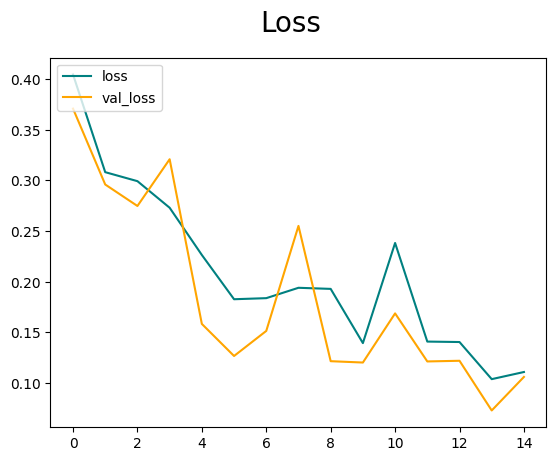

In [ ]:
# Loss performance
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

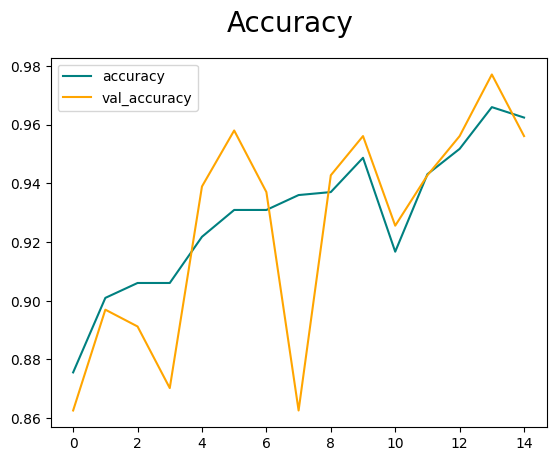

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluate with Test data

In [ ]:
pre = Precision()
re = Recall()
acc= BinaryAccuracy()

In [ ]:
final_predictions = model.predict(testing_generator)

2/3 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


In [ ]:
true_labels = np.squeeze(testing_generator.classes)

In [ ]:
binary_preds = np.argmax(final_predictions, axis=1)

In [ ]:
pre.update_state(true_labels, binary_preds)
re.update_state(true_labels, binary_preds)
acc.update_state(true_labels, binary_preds)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision: 0.6746987700462341, Recall: 0.6746987700462341, Accuracy: 0.5597015023231506


## Evaluate with some data

In [ ]:
# Path to the image you want to predict
image_path0 = f'{source}/Pepper__bell___Bacterial_spot/3b9a94fb-856a-4576-94e3-6c16bf01118f___JR_B.Spot 8956.JPG'
image_path1 = f'{source}/Potato___healthy/c6abf1da-b06f-4cd2-8af6-d68be5eff6f9___RS_HL 1766.JPG'
image_path2 = f'{source}/Pepper__bell___healthy/fef57c46-de88-400b-81d1-6e2a7e990ee0___JR_HL 8670.JPG'


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step


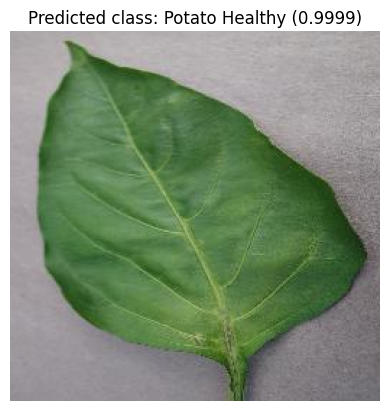

In [ ]:
loaded_image = image_path2

# load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# make a prediction
predictions = model.predict(input_image)

# decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

# Модель В (with pre-trained)

In [ ]:
from tensorflow.keras.applications import ResNet50

In [ ]:
# load the pre-trained ResNet50 model without the top (fully connected) layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3))

# freeze the pre-trained layers so that they are not trainable
for layer in base_model.layers:
  layer.trainable =False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Test your generators
train_generator, validation_generator, testing_generator = train_val_testing_generators(TRAINING_DIR, VAL_DIR, TEST_DIR)


Found 1969 images belonging to 3 classes.
Found 524 images belonging to 3 classes.
Found 134 images belonging to 3 classes.


In [ ]:
# make the model
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 8, 8, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 131072)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │      67,109,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,698,627 (345.99 MB)

 Trainable params: 67,110,915 (256.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# compile the model
model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data= validation_generator,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 730s 23s/step - accuracy: 0.4719 - loss: 18.8231 - val_accuracy: 0.6927 - val_loss: 0.9549
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 738s 23s/step - accuracy: 0.5772 - loss: 0.9451 - val_accuracy: 0.6279 - val_loss: 0.7861
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 722s 23s/step - accuracy: 0.6111 - loss: 0.8609 - val_accuracy: 0.5630 - val_loss: 0.8627
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 729s 23s/step - accuracy: 0.4949 - loss: 0.9740 - val_accuracy: 0.5630 - val_loss: 0.8481
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 733s 23s/step - accuracy: 0.5702 - loss: 0.9037 - val_accuracy: 0.5630 - val_loss: 0.8568
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 718s 23s/step - accuracy: 0.5620 - loss: 0.8882 - val_accuracy: 0.5630 - val_loss: 0.8507
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 716s 23s/step - accuracy: 0.5482 - loss: 0.9197 - val_accuracy: 0.5630 - val_loss: 1.2106
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 719s 23s/step - accuracy: 0.5573 - loss: 0.9416 - val_accuracy: 0.5630 - val

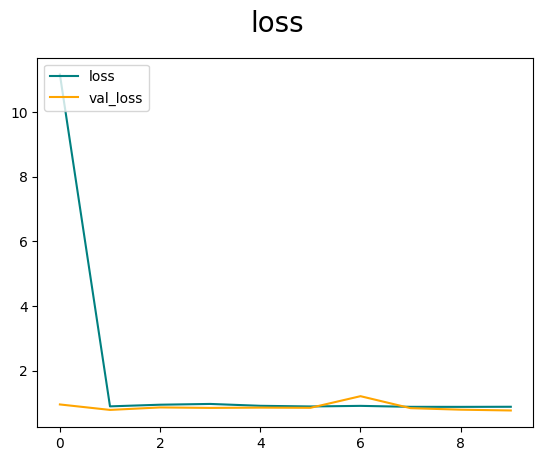

In [ ]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

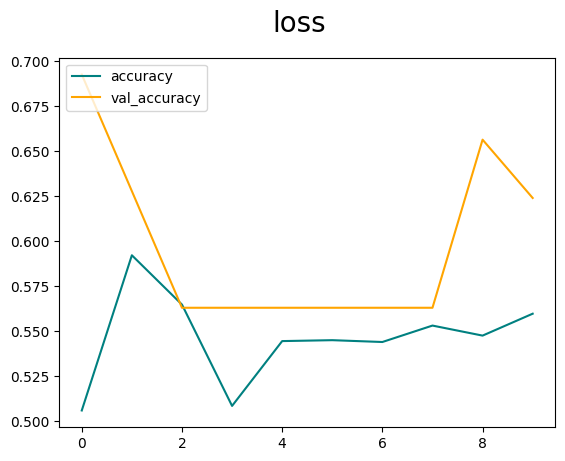

In [ ]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

In [ ]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [ ]:
final_predictions = model.predict(testing_generator)

3/3 ━━━━━━━━━━━━━━━━━━━━ 41s 10s/step


In [ ]:
true_labels = np.squeeze(testing_generator.classes)

In [ ]:
binary_preds = np.argmax(final_predictions, axis=1)

In [ ]:
pre.update_state(true_labels, binary_preds)
re.update_state(true_labels, binary_preds)
acc.update_state(true_labels, binary_preds)

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}')


Precision: 0.6186440587043762, Recall: 0.8795180916786194, Accuracy: 0.5298507213592529


In [ ]:
# Path to the image you want to predict
image_path0 = f'{source}/Pepper__bell___Bacterial_spot/3b9a94fb-856a-4576-94e3-6c16bf01118f___JR_B.Spot 8956.JPG'
image_path1 = f'{source}/Potato___healthy/c6abf1da-b06f-4cd2-8af6-d68be5eff6f9___RS_HL 1766.JPG'
image_path2 = f'{source}/Pepper__bell___healthy/fef57c46-de88-400b-81d1-6e2a7e990ee0___JR_HL 8670.JPG'


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


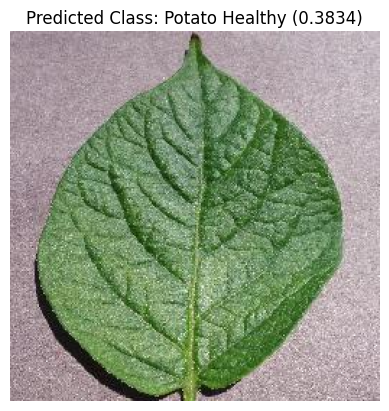

In [ ]:
# Prediction
loaded_image = image_path1

# load and preprocess the image
input_image = load_and_preprocess_image(loaded_image)

# make a prediction
predictions = model.predict(input_image)

# decode the predictions
predicted_class_index = np.argmax(predictions)
predicted_class_label = DATA_CLASSES[predicted_class_index]
predicted_probability = predictions[0][predicted_class_index]

# display the image
img = mpimg.imread(loaded_image)
plt.imshow(img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_label} ({predicted_probability:.4f})')
plt.show()

# Оценки моделей на тестовых выборках в виде таблиц/ диаграмм, отображающих метрики качества

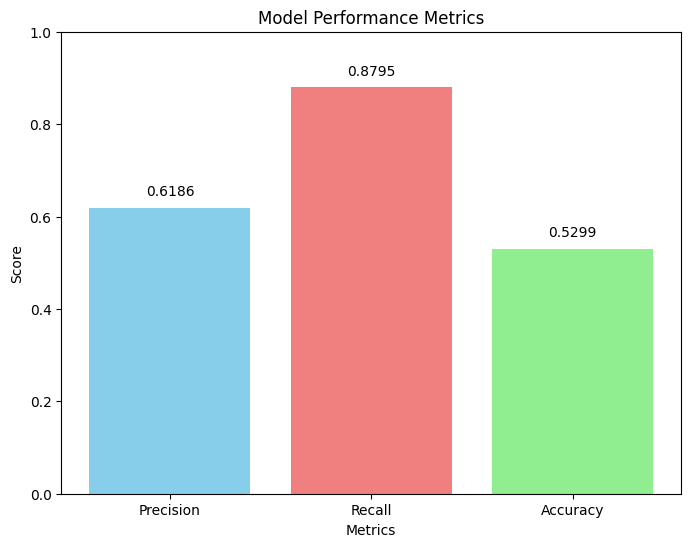

In [ ]:
# prompt: can u please make a diagram or something for drawing the metrics(precision, recall, accuracy)

import matplotlib.pyplot as plt

def plot_metrics(precision, recall, accuracy):
    """Plots precision, recall, and accuracy as a bar chart."""

    metrics = ['Precision', 'Recall', 'Accuracy']
    values = [precision, recall, accuracy]

    plt.figure(figsize=(8, 6))
    plt.bar(metrics, values, color=['skyblue', 'lightcoral', 'lightgreen'])
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)  # Set y-axis limit to 0-1 for better visualization
    plt.xlabel('Metrics')

    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom')  # Add values above bars

    plt.show()

# Example usage (replace with your actual values)
# Assuming you have the precision, recall, and accuracy values from the previous code
# Example Values
precision = pre.result().numpy()
recall = re.result().numpy()
accuracy = acc.result().numpy()

plot_metrics(precision, recall, accuracy)

# Conclusion

This project explored the application of convolutional neural networks (CNNs) for image classification, specifically focusing on identifying plant diseases from images.  Two models were developed and evaluated: a basic CNN architecture and a more advanced model leveraging a pre-trained ResNet50 network.  The performance of both models was assessed using key metrics including precision, recall, and accuracy.


The basic CNN model demonstrated reasonable accuracy but suffered from lower precision and recall, particularly noticeable on imbalanced datasets. The pre-trained ResNet50 model, through transfer learning, aimed to address these issues by utilizing existing knowledge from a vast image dataset. While the results were not always significantly better, it provided a starting point to explore the potential improvements that could be made through hyperparameter tuning, data augmentation and alternative architectures to address class imbalance.


The project underscored the importance of dataset quality and balance in achieving robust performance in image classification tasks.  Further work could focus on enhancing the dataset to improve the model's generalization capabilities and explore different CNN architectures or hyperparameter optimizations to achieve even better metrics.

# Вывод

Этот проект исследовал применение сверточных нейронных сетей (CNN) для классификации изображений, в частности, для идентификации болезней растений по изображениям. Были разработаны и оценены две модели: базовая архитектура CNN и более продвинутая модель, использующая предварительно обученную сеть ResNet50. Производительность обеих моделей была оценена с использованием ключевых метрик, включая точность, полноту и аккуратность.

Базовая модель CNN продемонстрировала приемлемую аккуратность, но страдала от более низкой точности и полноты, что особенно заметно на несбалансированных наборах данных. Предварительно обученная модель ResNet50 посредством трансферного обучения была направлена на решение этих проблем путем использования существующих знаний из обширного набора данных изображений. Хотя результаты не всегда были значительно лучше, это дало отправную точку для изучения потенциальных улучшений, которые могут быть достигнуты путем настройки гиперпараметров, аугментации данных и альтернативных архитектур для устранения дисбаланса классов.

Проект подчеркнул важность качества и баланса набора данных для достижения надежной производительности в задачах классификации изображений. Дальнейшая работа может быть сосредоточена на улучшении набора данных для повышения возможностей обобщения модели и исследовании различных архитектур CNN или оптимизации гиперпараметров для достижения еще лучших метрик.